Imagine we’re creating a learning thermostat. Over the course of the day, the homeowner occasionally sets the thermostat manually, providing a labeled data point. For example, the homeowner might prefer cooler temperatures at night, for better sleeping, and warmer temperatures when waking up. 

The thermostat needs to learn a complete schedule that is, what temperature target to use throughout the day.

For this simplified example, the data we’ll use to train the network is samples from a sine wave. In a more realistic example, we’d want to collect real-world preference data.

We construct a network in by importing a few libraries from pytorch. `torch` is the main library that handles tensors and computing derivatives. `nn` is a neural network library for creating layers and training them. And `F` is the `functional` library within `nn` that captures the layers. `F` is one of two basic methods for creating layers in torch --- specifically, it is a method where each layer is given the previous layer as input. It’s called `functional` because, in mathematics, a `functional` is a function that takes functions as inputs and produces a function as output.

The subroutine `net` is our program with unspecified values for turning, three layers of weights, each of which is a fully connected set of units that are first activated as a linear function, then passed through a rectifying linear unit, or relu.

The unspecified values are carried along in the parameter data structure `params`, a data list so they can be treated as a unit.


In [ ]:
!pip install torch=='1.5.0+cu101'
import torch
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import random

def net(x, params):
    x = F.linear(x, params[0], params[1])
    x = F.relu(x)
 
    x = F.linear(x, params[2], params[3])
    x = F.relu(x)
 
    x = F.linear(x, params[4], params[5])
    return x
 
params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),
 
    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),
 
    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

ERROR: Could not find a version that satisfies the requirement torch==1.5.0+cu101 (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 0.3.1, 0.4.0, 0.4.1, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1)
ERROR: No matching distribution found for torch==1.5.0+cu101


This `trainme` function describes the training process for our weights, `params`. The training data `x` is randomly generated, and the number of tranining examples `npoints`.  The labeled values `y` is calculated using a `sin` function based on `x`.  

`alpha` is a our learning rate used in training.

We make gradient updates, repeating `niters = 10000` number of iterations. To compute the gradient, we put the data, `x`, through our network, `net`. Note that we give the network the `x` coordinates we are using for training and the `params` of the network.

We use `l1_loss`, which is the absolute-value difference between the network’s predicted outputs, `f` and the target values, `y`.

We then compute the gradient, `grad`, of our loss function given the parameters, `params`. The gradient tells us what direction the parameters need to move to reduce the loss the most. 

We print the loss over time during training.

Finally, we plot the learned predictions `test_f`, given our test data, `test_x` and `test_y`.

In [ ]:
def trainme(npoints,params):
  niters = 10000
  b = torch.rand(1)*4*math.pi/2
  x = torch.rand(npoints, 1)*4*math.pi - 2*math.pi
  y = torch.sin(x + b)
 
  alpha = 3e-2
  for k in range(niters):
    f = net(x, params)
    loss = F.l1_loss(f, y)
 
    grads = torch.autograd.grad(loss, params, create_graph=True)
    params = [(params[i] - alpha*grads[i]) for i in range(len(params))]
 
    if k % 1000 == 0: print('Iteration %d -- Loss: %.4f' % (k, loss))

  test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
  test_y = torch.sin(test_x + b)

  test_f = net(test_x, params)

  plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
  plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
  plt.plot(x.data.numpy(), y.numpy(), 'o', label='data')
  plt.legend()

Below is the result of running `trainme` on 25 datapoints.

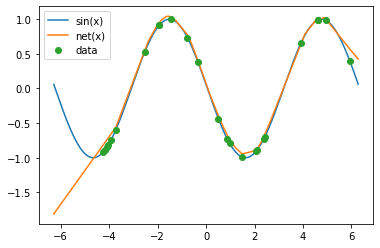

In [ ]:
trainme(25, params)

Here, we run `trainme` on 10 datapoints.

Iteration 0 -- Loss: 0.9598
Iteration 1000 -- Loss: 0.0335
Iteration 2000 -- Loss: 0.0698
Iteration 3000 -- Loss: 0.0442
Iteration 4000 -- Loss: 0.0386
Iteration 5000 -- Loss: 0.0338
Iteration 6000 -- Loss: 0.0543
Iteration 7000 -- Loss: 0.0300
Iteration 8000 -- Loss: 0.0518
Iteration 9000 -- Loss: 0.0502


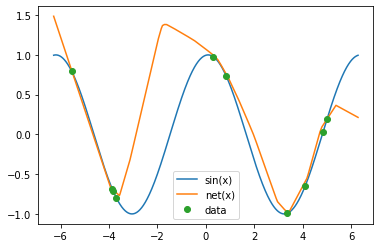

In [ ]:
trainme(10, params)

We run `traime` on 4 datapoints below. 

Iteration 0 -- Loss: 0.8361
Iteration 1000 -- Loss: 0.4006
Iteration 2000 -- Loss: 0.4094
Iteration 3000 -- Loss: 0.3802
Iteration 4000 -- Loss: 0.3770
Iteration 5000 -- Loss: 0.3444
Iteration 6000 -- Loss: 0.1957
Iteration 7000 -- Loss: 0.0944
Iteration 8000 -- Loss: 0.1153
Iteration 9000 -- Loss: 0.0286


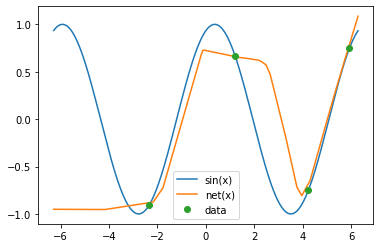

In [ ]:
trainme(4, params)

Now we learn a set of initial weights that will perform well across different sine wave functions.

We wrap the learning algorithm we just used to predict the sine wave *inside* another loop that will train the algorithm many times with many different datasets. The problem being solved by the outer loop is: Find initial parameters that make the inner loop learning algorithm learn accurate predictions across the space of possible homeowners.

The outer optimization will be performed by torch’s implementation of stochastic gradient descent, `SGD`, with a learning rate, `lr`, of 1e-2 or 0.01. The outer loop loss, `loss2`, is a measure of how good a job the *inner* loop did at predicting new datapoints for the homeowner.
The only parameters it has to manipulate to improve this loss is the initial parameters, `params`. PyTorch is taking the derivative through the entire inner loop gradient descent algorithm, *differentiating* the inner learning algorithm itself to find an improved value of `params`.

The number of steps of stochastic gradient descent used for each homeowner in the inner loop, is just 5, instead of our earelier 10,000 iterations. Its value is assigned by `n_inner_loop`.

For each iteration, `it`, we create a new function defined by a choice of the shift parameter, `b`. We collect 4 labeled data points from training. We also make 4 labeled data points for testing. Both training and testing use the same shift, `b`.

To learn this new function, we repeat the sine-wave learning code from earlier. The difference is that learning takes place on a copy of the parameters. That’s because there is a *shared* set of initial parameters across all datasets, but then the learning of the new sine function adapts independently.

We use gradient descent in the inner loop to learn the preferences of the homeowner and gradient descent in the outer loop *across* homeowners to learn good initial weight parameters for the inner loop.

That learning algorithm is carried out with the `SGD` optimizer. Its gradient computation is zeroed out *before* the inner loop. *After* the inner loop, we test the `new_params` parameters it learned for the current homeowner by predicting on four new points, represented by `v_x` and `v_y` and measuring this validation loss. The command `loss2.backward` triggers the gradient computation for the entire calculation since the gradient was zeroed out before the inner loop. Then, we have the `SGD` optimizer take a step.



In [ ]:
opt = torch.optim.SGD(params, lr=1e-2)
n_inner_loop = 5
alpha = 3e-2

 
for it in range(275000):
    b = random.choice([0, math.pi/2])
 
    x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    y = torch.sin(x + b)
 
    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)
 
    opt.zero_grad()
 
    new_params = params
    for k in range(n_inner_loop):
        f = net(x, new_params)
        loss = F.l1_loss(f, y)
 
        grads = torch.autograd.grad(loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]
 
        if it % 1000 == 0: print('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, loss))
 
    v_f = net(v_x, new_params)
    loss2 = F.l1_loss(v_f, v_y)
    loss2.backward()
 
    opt.step()
 
    if it % 100 == 0: print('Iteration %d -- Outer Loss: %.4f' % (it, loss2))

Iteration 0 -- Inner loop 0 -- Loss: 0.5580
Iteration 0 -- Inner loop 1 -- Loss: 0.8819
Iteration 0 -- Inner loop 2 -- Loss: 0.7242
Iteration 0 -- Inner loop 3 -- Loss: 0.5211
Iteration 0 -- Inner loop 4 -- Loss: 0.8739
Iteration 0 -- Outer Loss: 0.4945
Iteration 100 -- Outer Loss: 0.5724
Iteration 200 -- Outer Loss: 0.4131
Iteration 300 -- Outer Loss: 0.4889
Iteration 400 -- Outer Loss: 0.5093
Iteration 500 -- Outer Loss: 0.7401
Iteration 600 -- Outer Loss: 0.6258
Iteration 700 -- Outer Loss: 0.7296
Iteration 800 -- Outer Loss: 0.6150
Iteration 900 -- Outer Loss: 0.6111
Iteration 1000 -- Inner loop 0 -- Loss: 0.7061
Iteration 1000 -- Inner loop 1 -- Loss: 0.6990
Iteration 1000 -- Inner loop 2 -- Loss: 0.6913
Iteration 1000 -- Inner loop 3 -- Loss: 0.6828
Iteration 1000 -- Inner loop 4 -- Loss: 0.6735
Iteration 1000 -- Outer Loss: 0.5570
Iteration 1100 -- Outer Loss: 0.6539
Iteration 1200 -- Outer Loss: 0.4518
Iteration 1300 -- Outer Loss: 0.4977
Iteration 1400 -- Outer Loss: 0.6177
It

`testnet` defines a new function to plot the performance of the trained model, `net` on 4 new datapoints generated based on the shift parameter `b`.  We train the net for `n_inner_loop` iterations before plotting the results.

In [ ]:
def testnet(b):
  t_b = b # math.pi/2 or 0

  t_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
  t_y = torch.sin(t_x + t_b)

  opt.zero_grad()

  t_params = params
  for k in range(n_inner_loop):
      t_f = net(t_x, t_params)
      t_loss = F.l1_loss(t_f, t_y)

      grads = torch.autograd.grad(t_loss, t_params, create_graph=True)
      t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

  test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
  test_y = torch.sin(test_x + t_b)

  test_f = net(test_x, t_params)

  plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
  plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
  plt.plot(t_x.data.numpy(), t_y.data.numpy(), 'o', label='Examples')
  plt.legend()

Below we plot the results for `testnet` when `b` is 0.

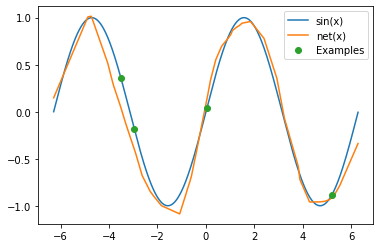

In [ ]:
testnet(0)

Below are the results for `b` equalling $\frac{\pi}{2}$

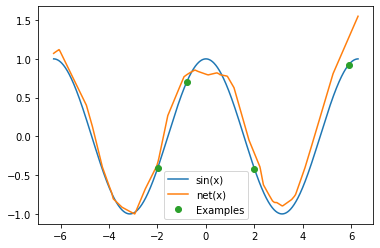

In [ ]:
testnet(math.pi/2)